In [11]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras.regularizers import L2
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [13]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-17 13:49:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.217.9.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-17 13:49:38 (118 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [14]:
model = Sequential()
model.add(
    # Your Embedding Layer
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1, name="embedding_1")
)
model.add(
    # An LSTM Layer
    Bidirectional(LSTM(units=150, return_sequences=True), name="LSTM_2")
)
model.add(
    # A dropout layer
    Dropout(rate=0.2, name="dropout_2")
)
model.add(
    # Another LSTM Layer
    LSTM(units=100, return_sequences=False, name="LSTM_3")
)
model.add(
    # A Dense Layer including regularizers
    Dense(units=total_words // 2, activation="relu", kernel_regularizer=L2(l2=0.01), name="dense_4")
)
model.add(
    # A Dense Layer
    Dense(units=total_words, activation="softmax", name="dense_5")
)
# Pick an optimizer
model.compile(
    # Pick a loss function and an optimizer
    optimizer=Adam(lr=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 10, 300)           301200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [15]:
 history = model.fit(predictors, label, epochs=100, verbose=1, workers=-1, use_multiprocessing=True)

Epoch 1/100
484/484 [==============================] - 9s 11ms/step - loss: 7.0890 - accuracy: 0.0215
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 6.5068 - accuracy: 0.0229
Epoch 3/100
484/484 [==============================] - 6s 12ms/step - loss: 6.4281 - accuracy: 0.0279
Epoch 4/100
484/484 [==============================] - 5s 11ms/step - loss: 6.3928 - accuracy: 0.0274
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 6.3343 - accuracy: 0.0326
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 6.3389 - accuracy: 0.0306
Epoch 7/100
484/484 [==============================] - 5s 11ms/step - loss: 6.2750 - accuracy: 0.0375
Epoch 8/100
484/484 [==============================] - 5s 11ms/step - loss: 6.2503 - accuracy: 0.0376
Epoch 9/100
484/484 [==============================] - 5s 10ms/step - loss: 6.2098 - accuracy: 0.0396
Epoch 10/100
484/484 [==============================] - 5s 11ms/step - loss: 6.187

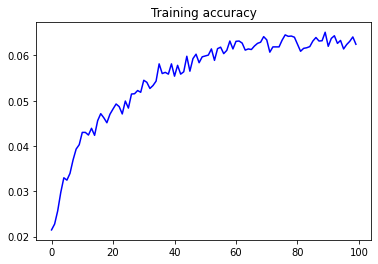

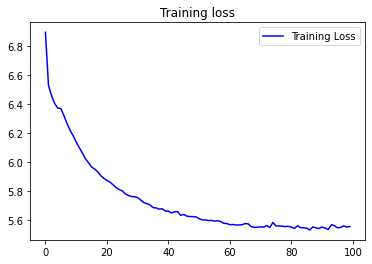

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [17]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope in the world and in the world to be in my love to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world to be in my love is i am in the world
